# Problem definition

**States:** For now, I think that it should also be stateless, since all the states I can think of are: 
- *posture quality:* (poor posture triggers the agent to make an action anyway, so it should be implemented as an iteration itself), 
- *time of the day:* since the experiment is not long, it can be just an input to the algorithm, for example to have a larger number of iterations
- *duration of usage:* could be implemented as $\epsilon$ the temperature for exploration vs. exploitation...?
- *last intervention/outcome:* ?? I don't even know how would this make difference, perhaps in the transition dynamics...
- *number of times the experiment has been conducted on that user:* also before the actual experiment???
should all of these parameters actually have an impact on those probabilities?
BUT, STATELESS IS ALSO A VERY SIMPLE SOLUTION... in this problem states then wouldn't be dependant on the actions that we take and that is what is confusing to me... 

states should be for example: head tilted to left, too close,...
the probabilities should change over time or whatever, and depend on each state too...
transition dynamics, what is a probability from going from one state to other etc...
all the states should be w.r.t to what we can actually measure, so because it is only tilt or too close/not, that is what the states should be refllective of

what is one learning step of our learning? to us i think event-based, when we detect bad posture...

create a class for a user and all his attributes?

how do we plan to deal with exploration/explotation balance...?

Proposal: should the states maybe be EA and EC and actions to transition to the other type of intervention or to remain on the same one?

**Actions:** Actions can take value of either EC - error correction or EA - error amplification.

**Reward system:** Either -1 (posture not corrected) or +1 (corrected) - how do we collect the actual reward in an iteration, what do we observe?

**Event-driven iterations:** Detection in the change of posture from good to poor is an event that triggers the agent to make an action. In the code, that is defined with a loop with max number of iterations. Should it depend on the user though? For example, we have some general information collected about the user, whether he/she has bad posture generally, what time of the day it is (if it's evening, the subject is most likely tired and has a bad posture - so interventions are triggered much more frequently, leading to more iterations overall).

**Non-episodic learning:** We start from Q values set to zero each time, this means that we don't learn anything from experiment to experiment



## Proposal:

### *Environment: (dependent on the user)*

**States:** two dimensions: **tilt** and **closeness** to the screen. 
- Along the **tilt** dimension, we have discretized the head roll angle to three possible values: *left*, *normal* and *right*. 
- Along the **closeness** dimension (*y* coordinate from the tablet) we can either have a *normal* distance or *too close* (below a certain threshold) - check in the paper for exact values.  

This forms a 2x3 state space, where the only valid posture that does not trigger the intervention is (normal, normal). The thing is that then, $p_{EC}$ and $p_{EA}$ should be incorporated in the transition matrix as the probability of getting from some state to the *normal* state (the probability of the intervention actually working, from each state and for each action/intervention). 

<img src="states.jpeg" alt="state space" width="400"/>

The question is: How to define iterations then? Is that the possibility of going from a normal state to other states? We need an action of doing nothing, and a high probability of going from the normal state to others,... while also that probability should get higher as the experiment goes on...
The problem also is the fact that a person can move from state to state regardless of the fact that our agent has taken an action or not... That is especially the case if the state is normal - our agent might learn to do nothing, but how do we impose that it actually goes to some other state, is it by transition matrix and a possibility of it going to some other state even though from neutal doing nothing should take you to a neutral state? Should a reward then be ending up in normal state +1, ending up in some other state -1?? 

**Actions:** 

EA - Error Amplification, EC - Error Correction, or DO NOTHING?

**Reward system:**

Either -1 (posture not corrected) or +1 (corrected, i.e. from a bad posture state transitioned to normal).

### Additional remarks:

Since in paper they say: "We cannot draw a conclusive conclusion about whether children's understanding of the intervention strategy influences the effectiveness of the system. Further experiments are still required.", maybe for now we do not simulate a single user doing the experiment multiple times. If we end up deciding to do so, then we have to create an agent for every user, which will learn from experiment to experiment, that won't be non-episodic learning anymore... 


In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'


In [2]:
import numpy as np
import tensorflow as tf
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts

### For now this is a stateless implementation

In [3]:
class QLearningEnv(tf_env.py_environment.PyEnvironment):
    # Encode action:
    # EC = 0
    # EA = 1
    def __init__(self, user_model_vec):
        # Defining the action space
        self._num_actions = 2
        # User specifications (intervention preferences) - probabilities vector
        self._user_model_vec = user_model_vec
        #self._true_action_values = 2 * np.array(user_model_vec, dtype=np.float32) - 1
        self._step_count = 0
        self._total_reward = 0.0
        super(QLearningEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self.Q = np.array([0.0, 0.0], dtype=np.float32) #non-episodic learning
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation = None)

    def _step(self, action):
        """
        Inputs:
        action - chosen action of the step with eps-greedy exploration
        alpha - a.k.a. learning_rate
        """
        # TODO: integrate with the physical environment here

        # define the reward method
        # reward = np.random.normal(self._true_action_values[action], 1.0) # the gaussian reward
        reward = 1 if np.random.uniform(0,1) < self._user_model_vec[action] else -1

        self._step_count += 1
        self._total_reward += reward

        if self._step_count == 1000:  # Limit the number of steps for this example - do we need this???
            return ts.termination(observation = None, reward = reward)
        else:
            return ts.transition(observation=None, reward = reward)

In [8]:
class EpsGreedyAgent:
    def __init__(self, num_actions, explore_rate = 1.0): #JEL JE OVO OK??? 
        self.num_actions = num_actions
        self.action_values = [0.0] * num_actions
        self.action_counts = [0] * num_actions
         # Initialization of Q values - TO MODIFY IF WE HAVE MORE STATES...
        self.Q = np.array([0.0, 0.0], dtype=np.float32)
        self.step_counts = 0
        self.explore = explore_rate  
        self.reward_history = []

    def select_action(self):
        # Should be selected on the basis of epsilon greedy

        explore = np.random.binomial(2, p=self.explore)
        if explore:
            # Exploration: With probability epsilon take a random action, an index of an action
            a = np.random.choice(np.arange(self.num_actions))
        else:
            # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
            a = np.argmax(self.Q)

        return a

    def update_estimates(self, action, reward, alpha):
        
        """
        Updates the values of action counts, step counts, reward history etc.

        Inputs:
        action - action taken in the current step
        reward - reward collected while taking the step when interacting with the environment

        """
        # Updating Q value of chosen action
        self.Q[action] = alpha*reward + (1-alpha)*self.Q[action] # it is a lot simpler because we have no states 
        
        self.action_counts[action] += 1
        self.step_counts += 1
        self.reward_history.append(reward)


    def get_current_average_reward(self):
        return np.mean(self.reward_history)
    
    def get_cumulative_reward(self):
        return np.sum(self.reward_history)

In [11]:
def user_simulation(user_model_vec, num_iterations = 500, explore_rate = 2.0, alpha = 0.5):
  """
  Inputs:

  user_model_vec:
  num_iterations: maximal number of iterations, in our problem this refers to the number of times the posture becomes poor, 
  i.e. number of interventions - should be modified to be dependant on the user and its attributes...
  explore_rate: maybe modify to be dependant on the period of the day...? explore more if it is evening and more fatigue...?

  Outputs:

  average_rewards:
  rmse:
  reward_history:

  """
  # Create the environment
  
  #true_action_value = 2 * np.array(user_model_vec) - 1
  env = QLearningEnv(user_model_vec)

  # Create the epsilon greedy agent
  agent = EpsGreedyAgent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)

  average_rewards = []
  rmse = []

  # Training loop
  for _ in range(num_iterations):
      # Take one step 
      action = agent.select_action()
      time_step = env._step(action)
      agent.update_estimates(action, time_step.reward, alpha)

      # Logs for plotting
      average_rewards.append(agent.get_current_average_reward()) # should we plot current average reward or current reward that is collected??
      

  # Evaluate the agent
  if False:
    total_reward = 0.0
    for _ in range(10):  # Test for 10 episodes
        time_step = env.reset()
        while not time_step.is_last():
            action = agent.select_action()
            time_step = env.step(action)
            total_reward += time_step.reward
    print(f'Average Reward of 10 episodes: {total_reward / 10 / 1000}')

  return average_rewards, rmse, agent.reward_history

### Simulation on one user

Text(0.5, 0, 'Number of Iterations')

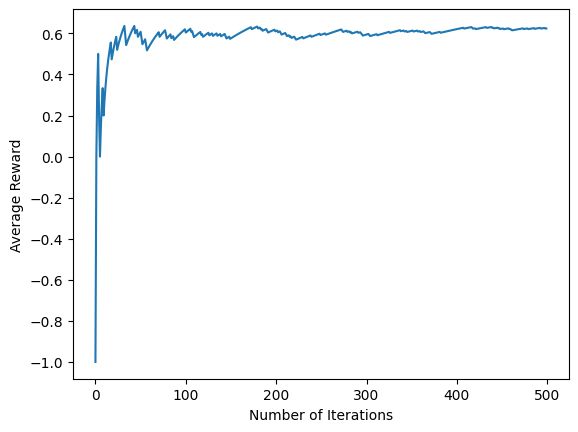

In [12]:
# fix random seed
np.random.seed(0)

average_rewards, rmse, reward_history = user_simulation(user_model_vec = [0.1, 0.9], explore_rate=0.1, alpha=0.7)

import matplotlib.pyplot as plt
plt.plot(average_rewards)
plt.ylabel('Average Reward')
plt.xlabel('Number of Iterations')